In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pyarrow.parquet as pq
import gc
import pywt
from statsmodels.robust import mad
import scipy
from scipy import signal
from scipy.signal import butter

import warnings

# Suppress pandas future warnings, I am using different library versions locally
# that do not raise warnings.
warnings.simplefilter(action='ignore', category=FutureWarning)

data_dir = '../input'

In [2]:
print(scipy.__version__)

1.1.0


In [3]:
metadata_train = pd.read_csv(data_dir + '/metadata_train.csv')
metadata_train.head()

,signal_id,id_measurement,phase,target
0,0,0,0,0
1,1,0,1,0
2,2,0,2,0
3,3,1,0,1
4,4,1,1,1


In [24]:
subset_train = pq.read_pandas(data_dir + '/train.parquet', columns=[str(i) for i in range(228,230)]).to_pandas()

In [25]:
subset_train.memory_usage(index=True).sum()

1600080

In [5]:
# 800,000 data points taken over 20 ms
# Grid operates at 50hz, 0.02 * 50 = 1, so 800k samples in 20 milliseconds will capture one complete cycle
n_samples = 800000

# Sample duration is 20 miliseconds
sample_duration = 0.02

# Sample rate is the number of samples in one second
# Sample rate will be 40mhz
sample_rate = n_samples * (1 / sample_duration)


In [6]:
def maddest(d, axis=None):
    """
    Mean Absolute Deviation
    """
    return np.mean(np.absolute(d - np.mean(d, axis)), axis)

In [7]:
def high_pass_filter(x, low_cutoff=1000, sample_rate=sample_rate):
    """
    From @randxie https://github.com/randxie/Kaggle-VSB-Baseline/blob/master/src/utils/util_signal.py
    Modified to work with scipy version 1.1.0 which does not have the fs parameter
    """
    
    # nyquist frequency is half the sample rate https://en.wikipedia.org/wiki/Nyquist_frequency
    nyquist = 0.5 * sample_rate
    norm_low_cutoff = low_cutoff / nyquist
    
    # Fault pattern usually exists in high frequency band. According to literature, the pattern is visible above 10^4 Hz.
    # scipy version 1.2.0
    #sos = butter(10, low_freq, btype='hp', fs=sample_fs, output='sos')
    
    # scipy version 1.1.0
    sos = butter(10, Wn=[norm_low_cutoff], btype='highpass', output='sos')
    filtered_sig = signal.sosfilt(sos, x)

    return filtered_sig

In [8]:
def denoise_signal( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[0:], wavelet, mode='per' )

In [10]:
from numpy.fft import *
from scipy import fftpack

In [11]:
def denoise_fft(s, threshold=1e7):
    fourier = rfft(s)
    frequencies = rfftfreq(s.size, d=2e-2/s.size)
    fourier[frequencies < threshold] = 0
    return fourier

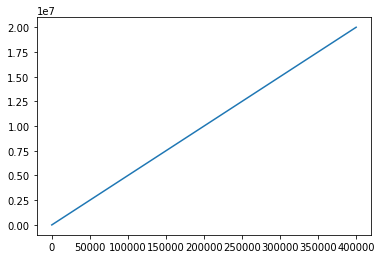

In [26]:
plt.plot(frequencies)

In [29]:
threshold=1e7
fourier[frequencies < threshold] = 0

/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


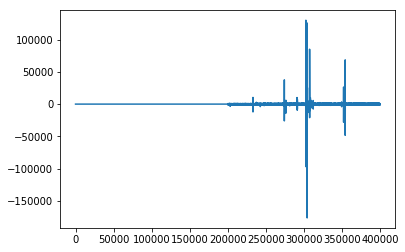

In [31]:
plt.plot(fourier)

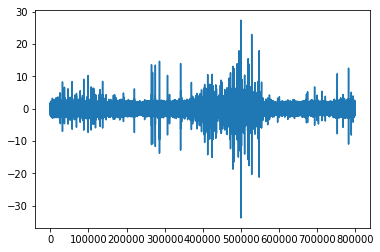

In [32]:
plt.plot(irfft(fourier))

/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


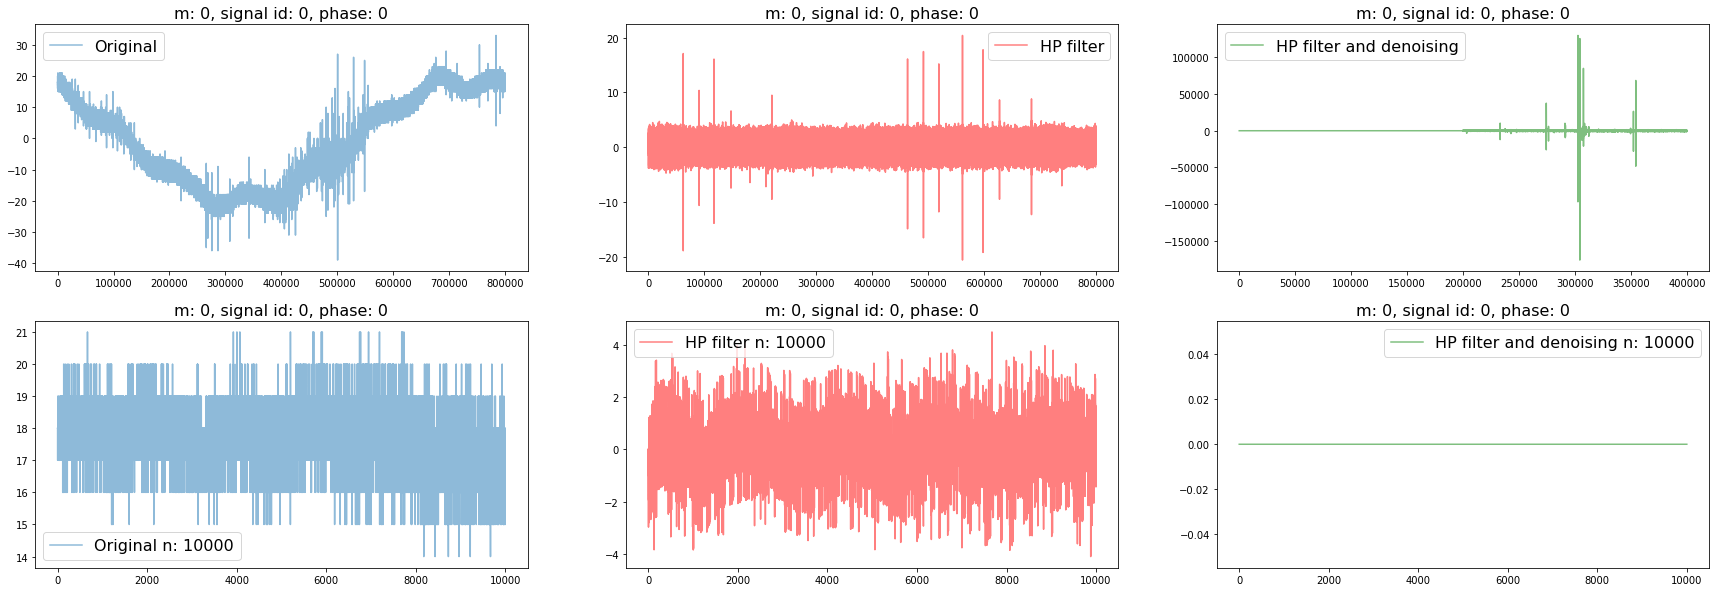

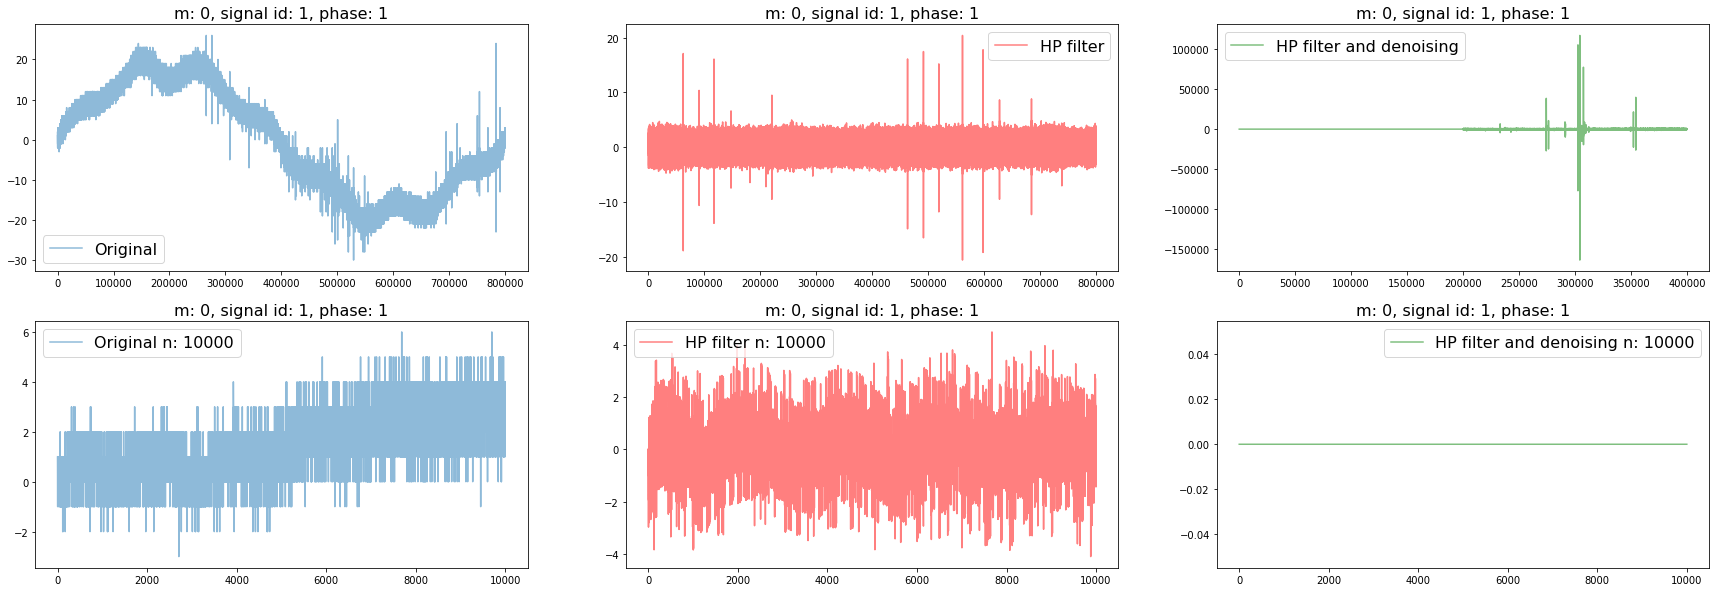

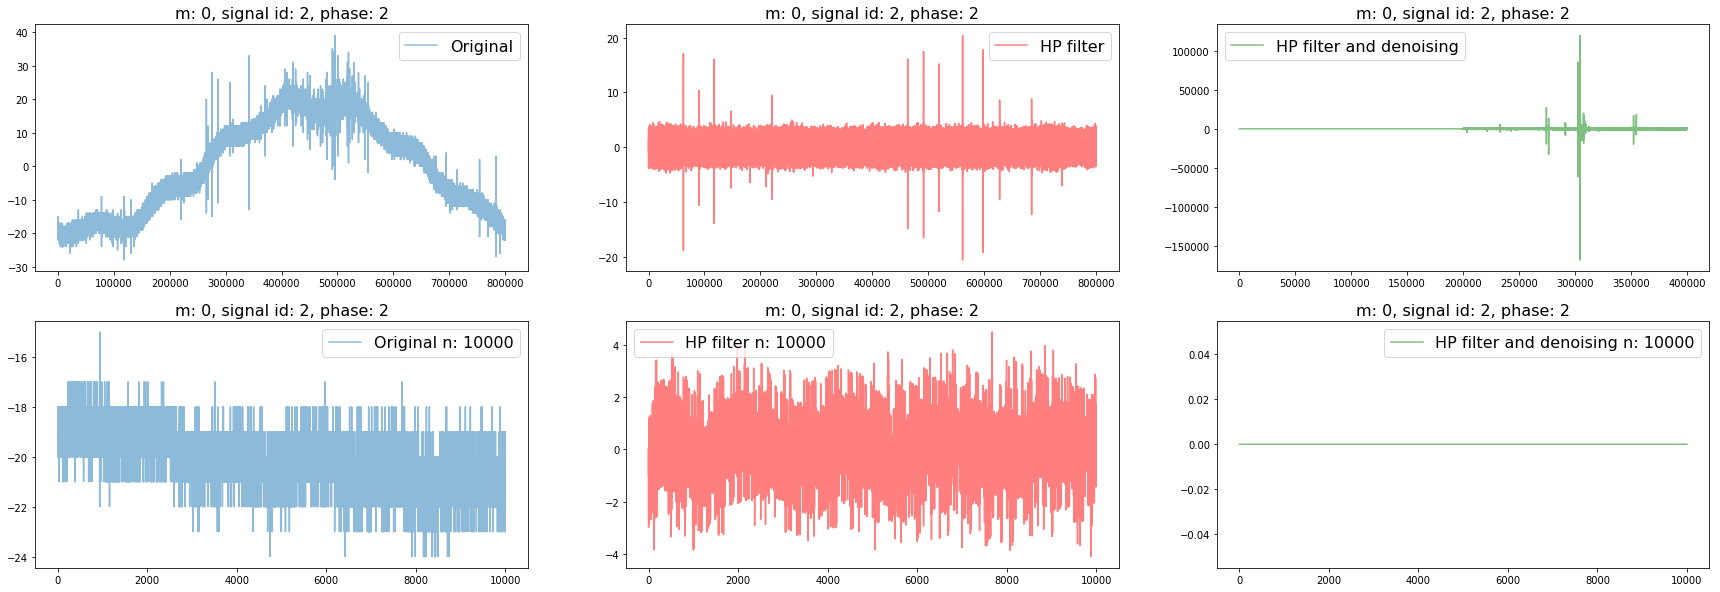

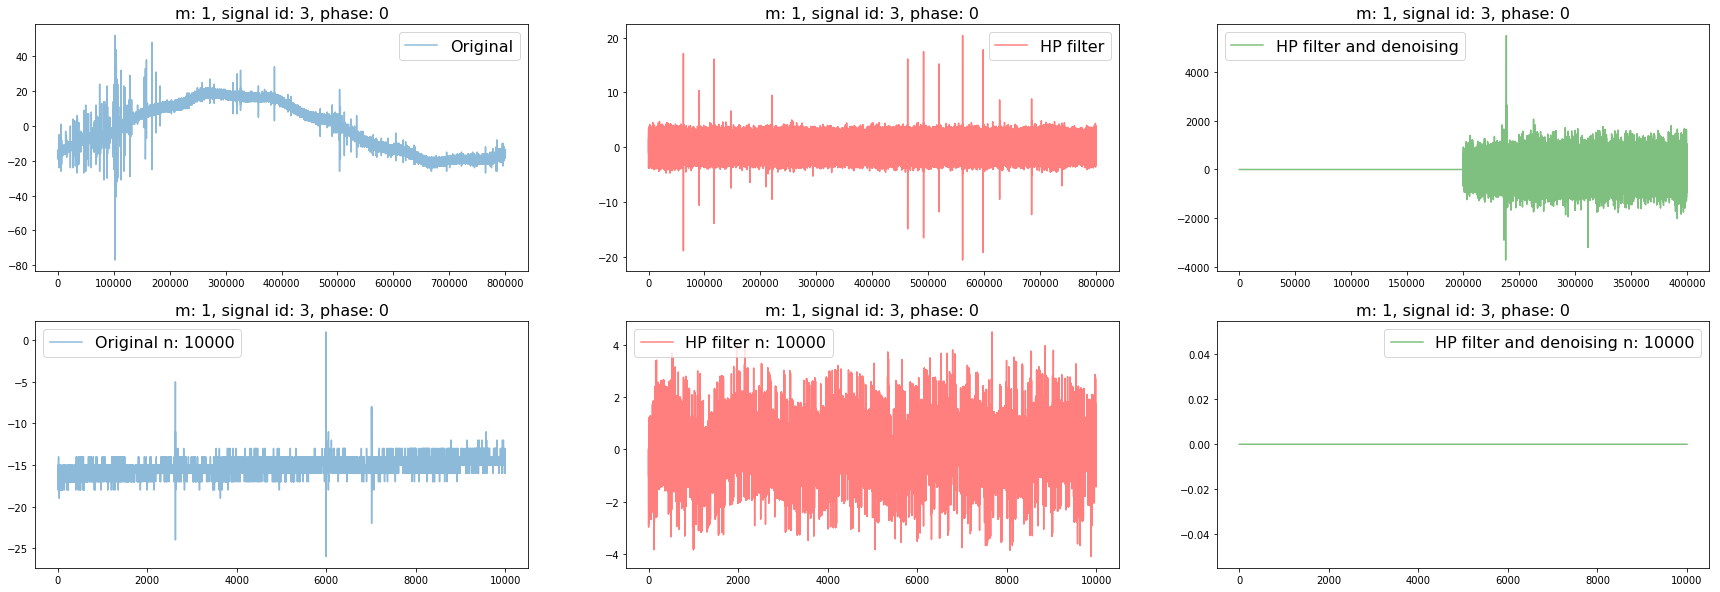

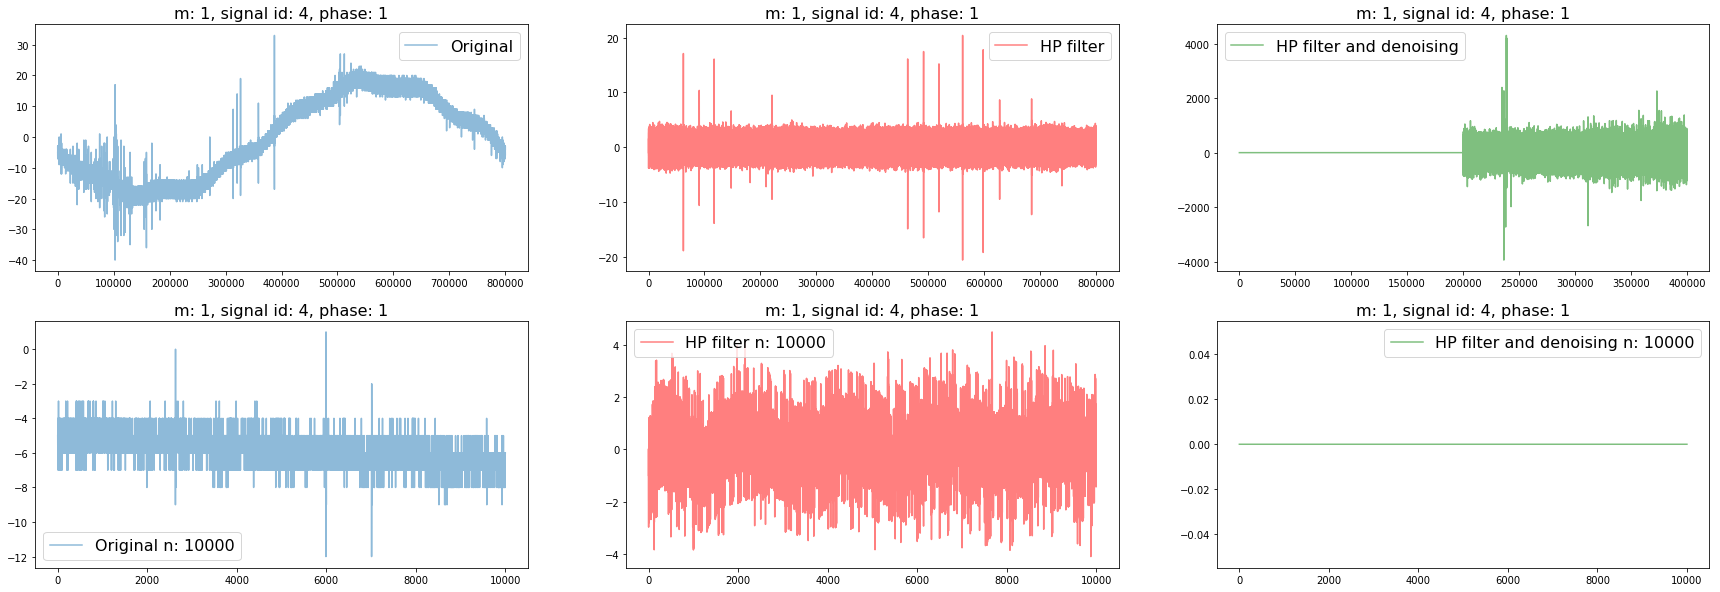

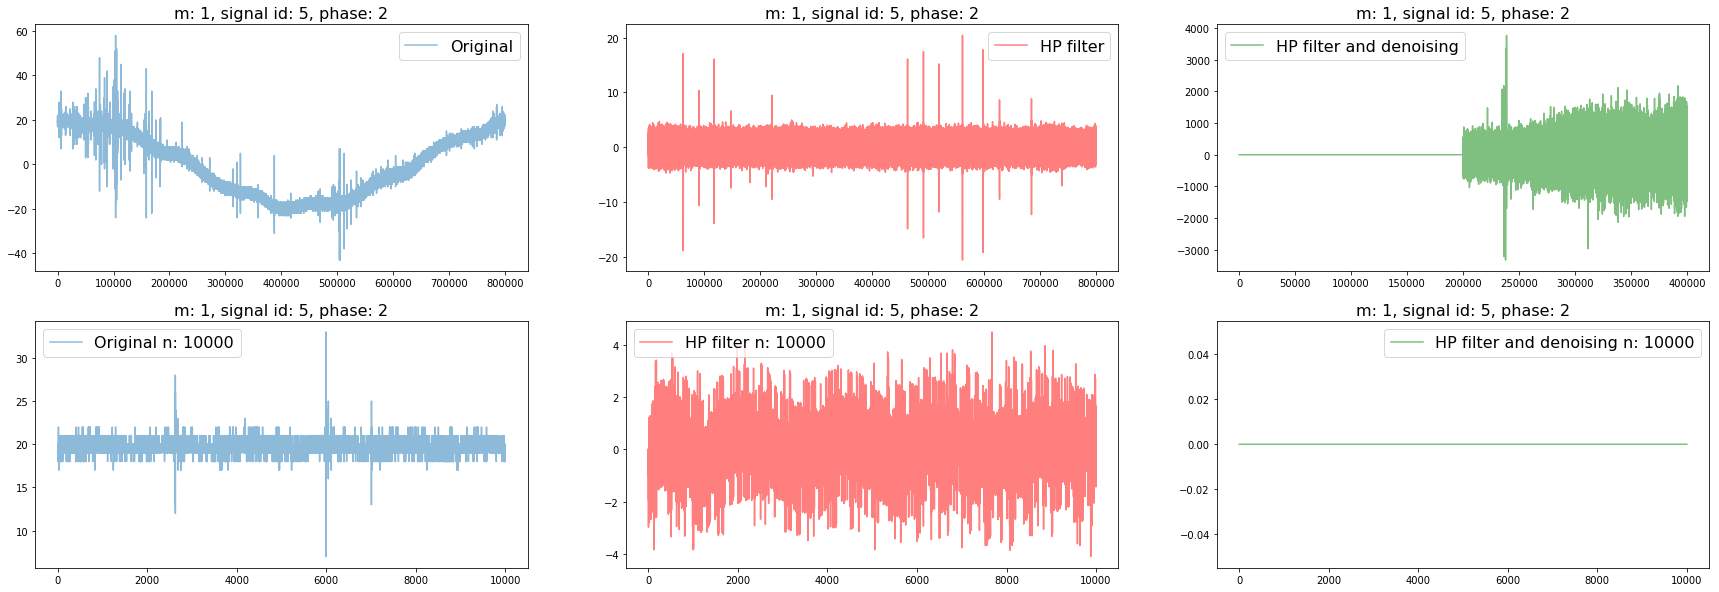

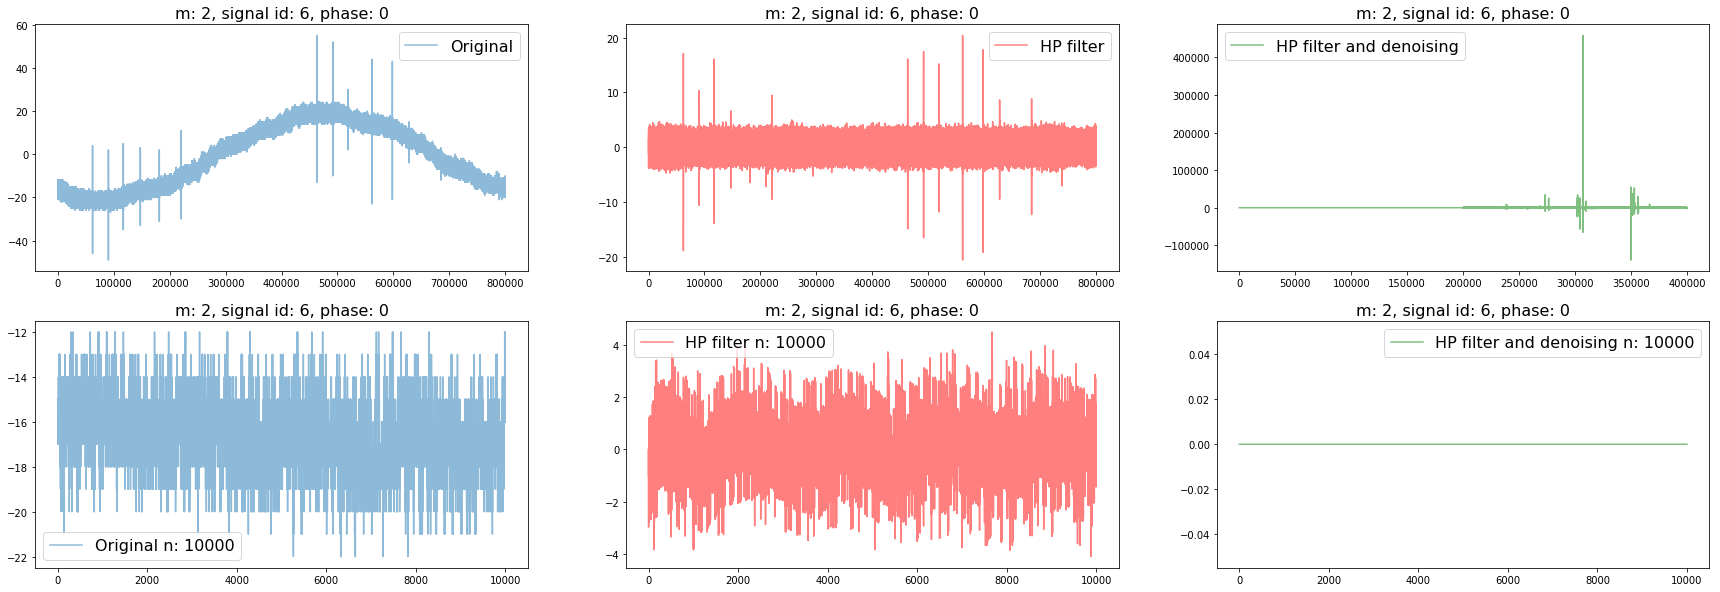

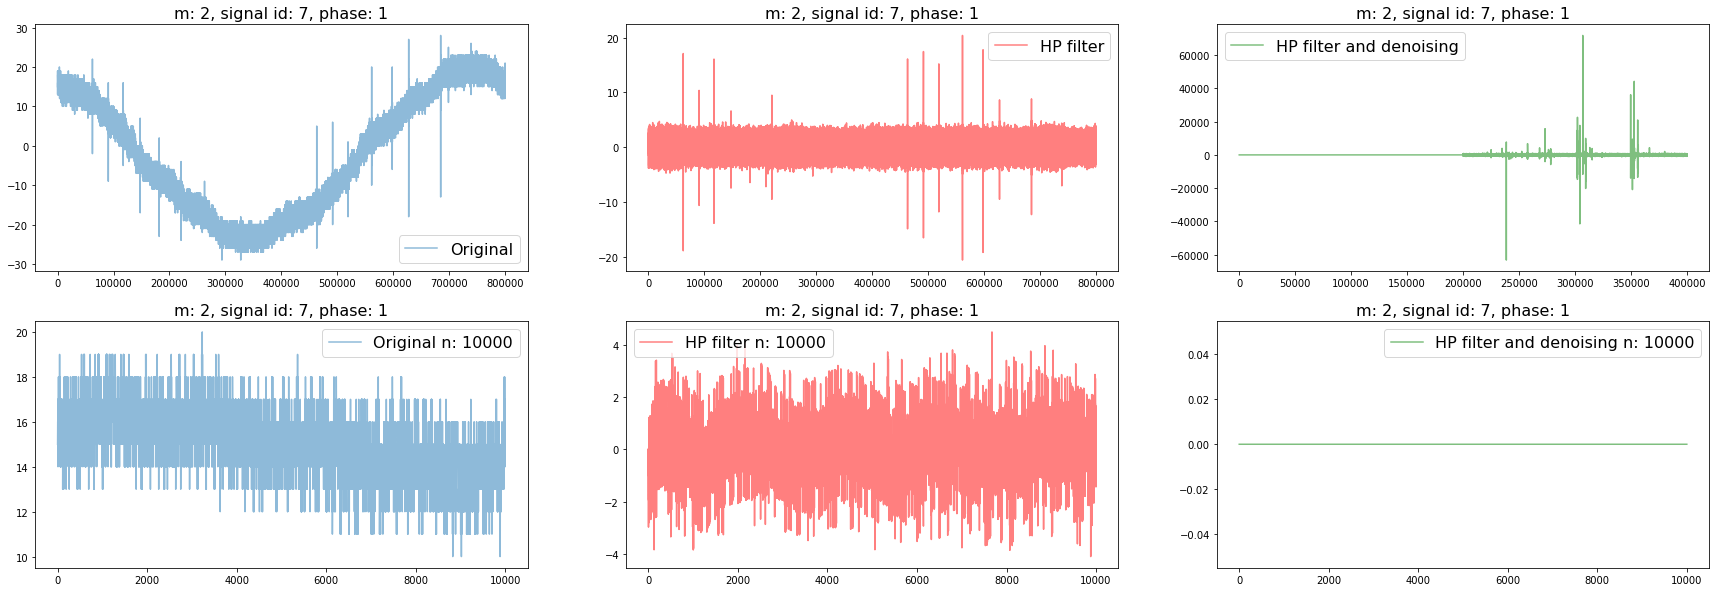

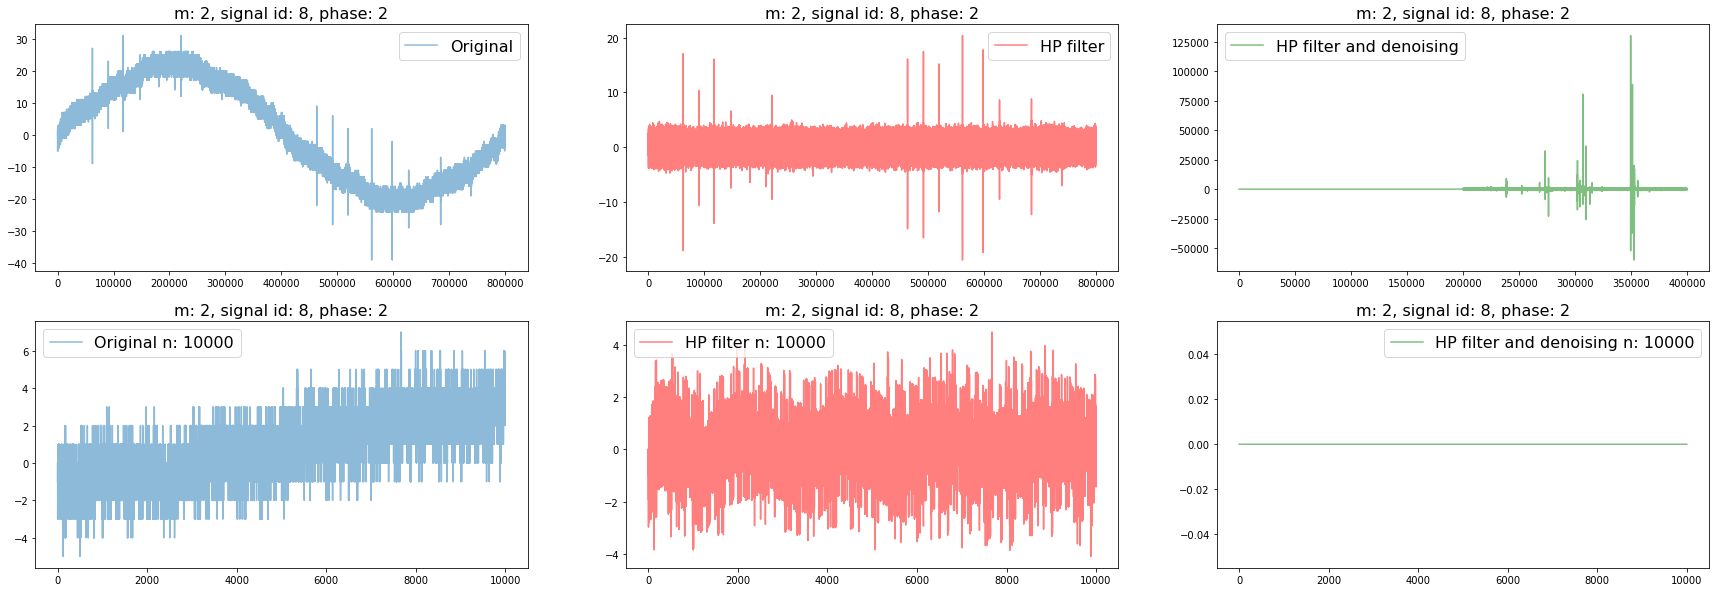

In [36]:
train_length = 9

for i in range(train_length):
    signal_id = str(i)
    meta_row = metadata_train[metadata_train['signal_id'] == i]
    measurement = str(meta_row['id_measurement'].values[0])
    signal_id = str(meta_row['signal_id'].values[0])
    phase = str(meta_row['phase'].values[0])
    
    subset_train_row = subset_train[signal_id]
    
    # Apply high pass filter with low cutoff of 10kHz, this will remove the low frequency 50Hz sinusoidal motion in the signal
    x_hp = high_pass_filter(subset_train_row, low_cutoff=10000, sample_rate=sample_rate)
    
    # Apply denoising
    x_dn = denoise_signal(x_hp, wavelet='haar', level=1)
    #x_dn = denoise_fft(subset_train_row)
    
    slice_size = 10000
    font_size = 16
    
    fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(30, 10))
    
    ax[0, 0].plot(subset_train_row, alpha=0.5)
    ax[0, 0].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 0].legend(['Original'], fontsize=font_size)
    
    # Show smaller slice of the signal to get a better idea of the effect the high pass frequency filter is having on the signal
    ax[1, 0].plot(subset_train_row[:slice_size], alpha=0.5)
    ax[1, 0].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 0].legend([f"Original n: {slice_size}"], fontsize=font_size)
    
    ax[0, 1].plot(x_hp, 'r', alpha=0.5)
    ax[0, 1].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 1].legend(['HP filter'], fontsize=font_size)
    ax[1, 1].plot(x_hp[:slice_size], 'r', alpha=0.5)
    ax[1, 1].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 1].legend([f"HP filter n: {slice_size}"], fontsize=font_size)
    
    ax[0, 2].plot(x_dn, 'g', alpha=0.5)
    ax[0, 2].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[0, 2].legend(['HP filter and denoising'], fontsize=font_size)
    ax[1, 2].plot(x_dn[:slice_size], 'g', alpha=0.5)
    ax[1, 2].set_title(f"m: {measurement}, signal id: {signal_id}, phase: {phase}", fontsize=font_size)
    ax[1, 2].legend([f"HP filter and denoising n: {slice_size}"], fontsize=font_size)
    
    plt.show()

In [48]:
x_hp = high_pass_filter(subset_train.iloc[:, 1], low_cutoff=10000, sample_rate=sample_rate)

x_dn = denoise_signal(x_hp, wavelet='haar', level=1)

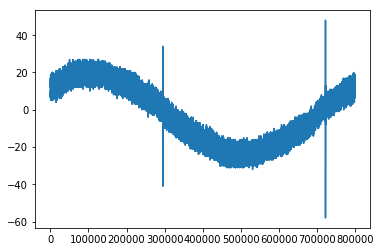

In [49]:
plt.plot(subset_train.iloc[:, 1])

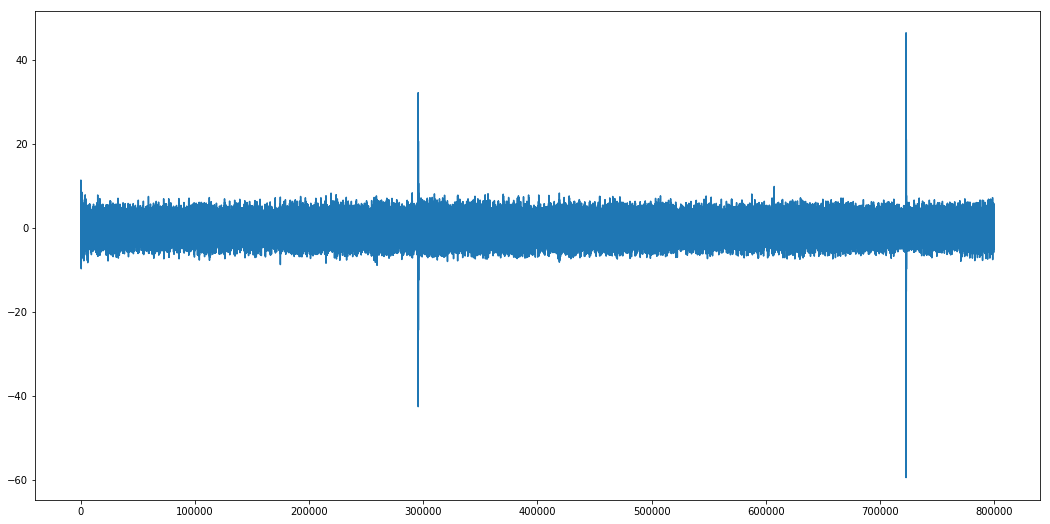

In [51]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

In [25]:
pd.Series(x_dn).loc[np.abs(x_dn)>0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

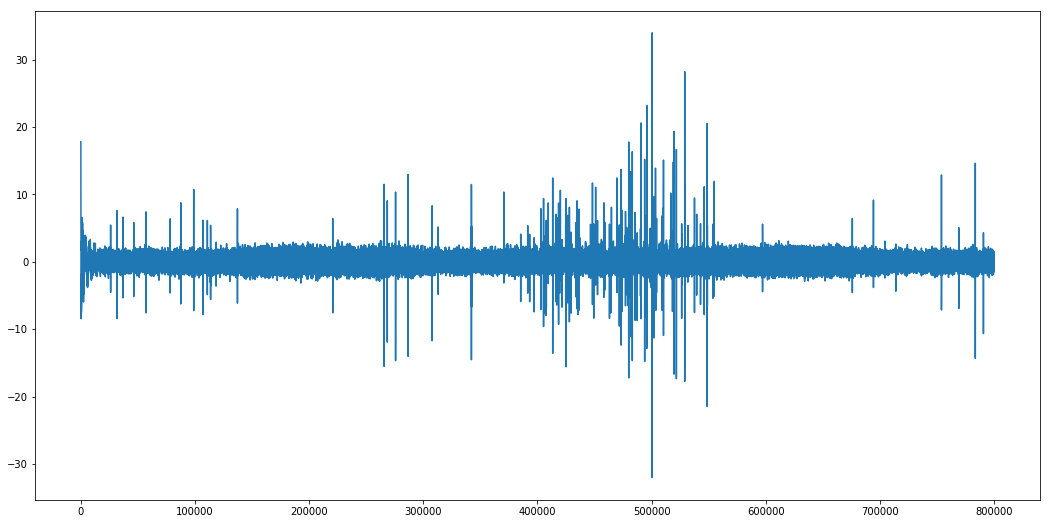

In [16]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

In [25]:
pd.Series(x_dn).loc[np.abs(x_dn)>0].index

Int64Index([     0,      1,      2,      3,      4,      5,      6,      7,
                 8,      9,
            ...
            799990, 799991, 799992, 799993, 799994, 799995, 799996, 799997,
            799998, 799999],
           dtype='int64', length=800000)

In [19]:
def remove_colona(x_dn, maxDistance=10, maxHeightRatio=0.25, maxTicksRemoval=500):    
    index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
    for idx in index:
        for i in range(1,maxDistance+1):
            if idx+i < pd.Series(x_dn).shape[0]:
                if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                    x_dn[idx:idx+maxTicksRemoval] = 0
    return x_dn

In [22]:
x_dn_rm = remove_colona(x_dn)

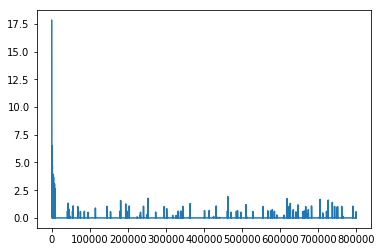

In [23]:
plt.plot(x_dn)

In [9]:
def denoise_signal_2( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = (1/0.6745) * maddest( coeff[-level] )

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[1:], wavelet, mode='per' )

In [52]:
x_hp = high_pass_filter(subset_train.iloc[:, 1], low_cutoff=10000, sample_rate=sample_rate)

x_dn = denoise_signal_2(x_hp, wavelet='haar', level=1)

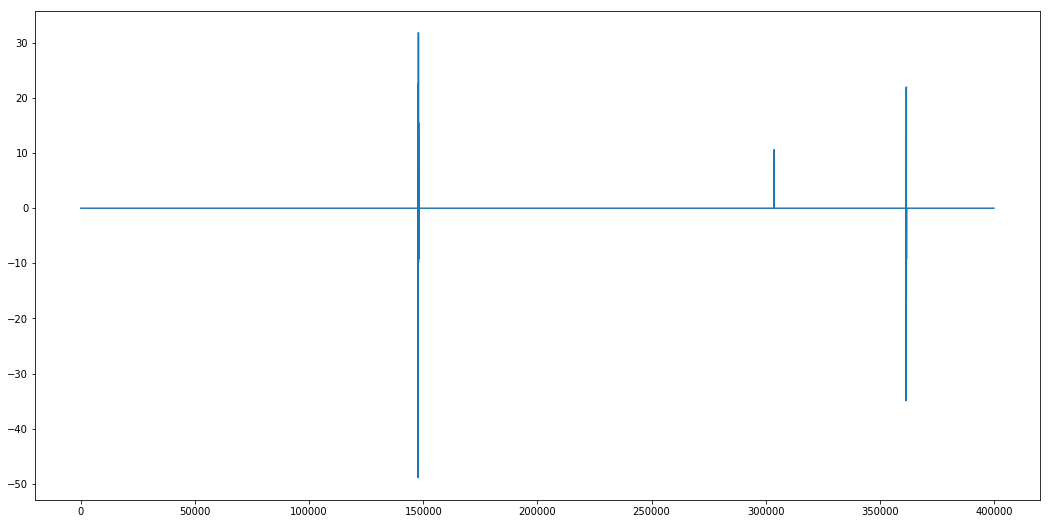

In [53]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

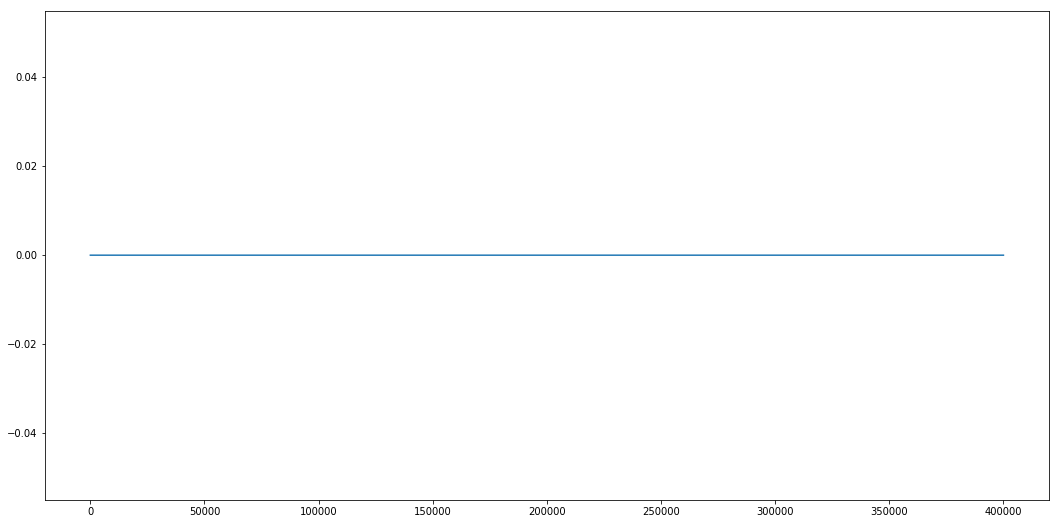

In [34]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

In [32]:
def remove_colona(x_dn, maxDistance=10, maxHeightRatio=0.25, maxTicksRemoval=500):    
    index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
    colona_idx = []
    for idx in index:
        for i in range(1,maxDistance+1):
            if idx+i < pd.Series(x_dn).shape[0]:
                if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                    x_dn[idx:idx+maxTicksRemoval] = 0
                    colona_idx.append(idx)
    return x_dn, colona_idx

In [40]:
x_dn, colona_idx = remove_colona(x_dn)

In [41]:
colona_idx

[147777, 361505]

In [44]:
colona_idx = np.array(colona_idx)*2

In [45]:
x_hp = high_pass_filter(subset_train.iloc[:, 0], low_cutoff=10000, sample_rate=sample_rate)

x_dn = denoise_signal(x_hp, wavelet='haar', level=1)

for idx in colona_idx:
    x_dn[idx:idx+500] = 0

In [47]:
pd.Series((x_dn==0)).value_counts()

False    799000
True       1000
dtype: int64

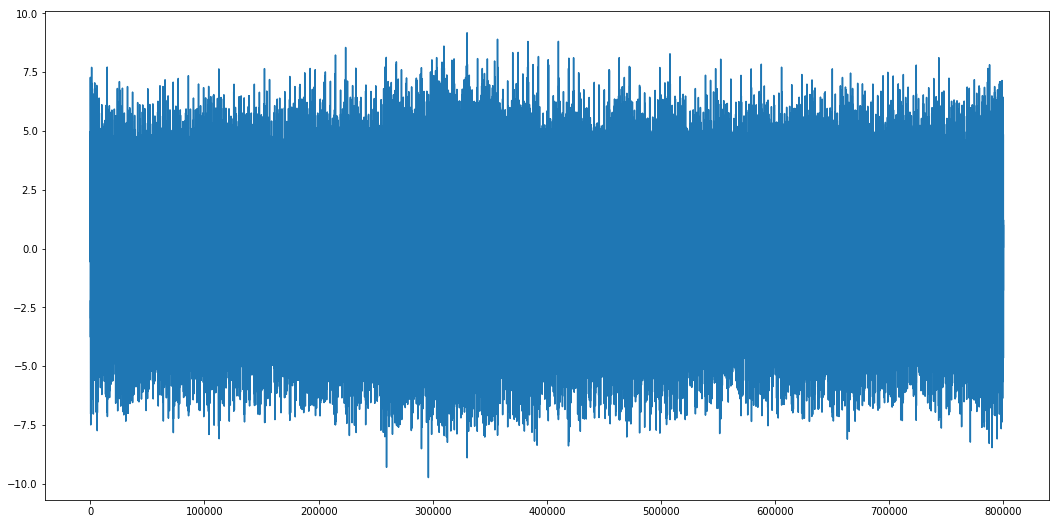

In [46]:
plt.figure(figsize=(18, 9))
plt.plot(x_dn)

In [ ]:
sigma = (1/0.6745) * maddest( coeff[-level] )

uthresh = sigma * np.sqrt( 2*np.log( len( x ) 

In [43]:
wavelet='haar'
level=1

coeff = pywt.wavedec(subset_train.iloc[:, 0] , wavelet, mode="per", level=level)
    
# Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
# As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
sigma = (1/0.6745) * maddest( coeff[-level] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( subset_train.iloc[:, 0] ) ) )
#coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

In [46]:
maddest( coeff[-level] )

0.8301595986358328

In [48]:
1/(0.6745 * maddest( coeff[-level] ))* np.sqrt( 2*np.log( len( subset_train.iloc[:, 0] ) ) )

9.311486034845796

In [45]:
sigma

1.2307777592821836

In [44]:
uthresh

6.417149893362979

In [51]:
def denoise_signal_3( x, wavelet='db4', level=1):
    """
    1. Adapted from waveletSmooth function found here:
    http://connor-johnson.com/2016/01/24/using-pywavelets-to-remove-high-frequency-noise/
    2. Threshold equation and using hard mode in threshold as mentioned
    in section '3.2 denoising based on optimized singular values' from paper by Tomas Vantuch:
    http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    """
    
    # Decompose to get the wavelet coefficients
    coeff = pywt.wavedec( x, wavelet, mode="per", level=level)
    
    # Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
    # As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
    sigma = 1/(0.6745 * maddest( coeff[-level] ))

    # Calculte the univeral threshold
    uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
    coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )
    
    # Reconstruct the signal using the thresholded coefficients
    return pywt.waverec( coeff[0:], wavelet, mode='per' )

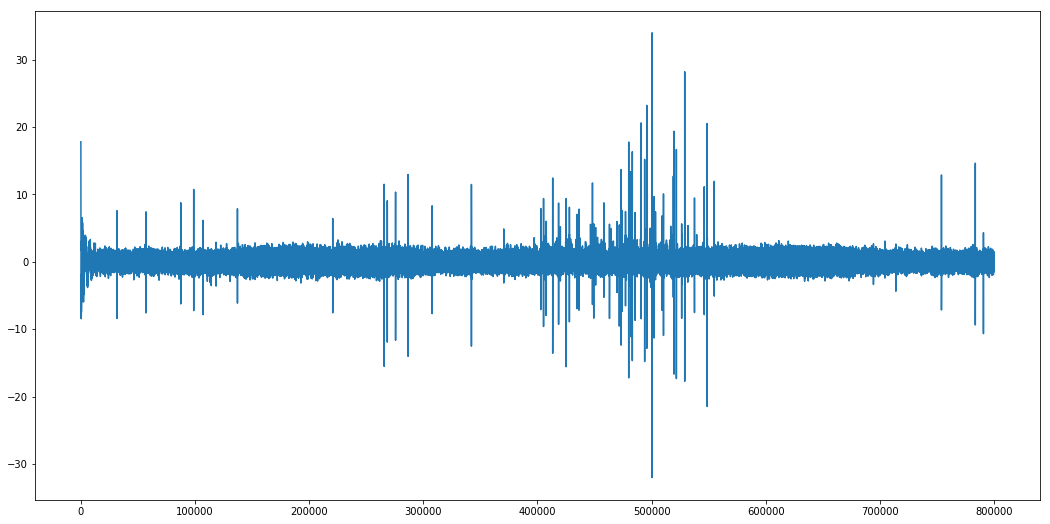

In [52]:
x_hp = high_pass_filter(subset_train.iloc[:, 0], low_cutoff=10000, sample_rate=sample_rate)

x_dn = denoise_signal_3(x_hp, wavelet='haar', level=1)

plt.figure(figsize=(18, 9))
plt.plot(x_dn)

In [37]:
metadata_train[metadata_train['target']==1]

,signal_id,id_measurement,phase,target
3,3,1,0,1
4,4,1,1,1
5,5,1,2,1
201,201,67,0,1
202,202,67,1,1
228,228,76,0,1
229,229,76,1,1
230,230,76,2,1
270,270,90,0,1
271,271,90,1,1


In [38]:
subset_train = pq.read_pandas(data_dir + '/train.parquet').to_pandas()

/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


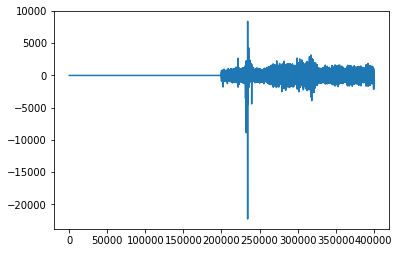

In [40]:
plt.plot(denoise_fft(subset_train.iloc[:, 228]))

/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


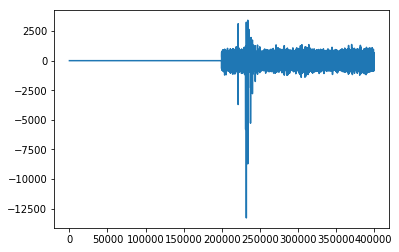

In [41]:
plt.plot(denoise_fft(subset_train.iloc[:, 229]))

/home/cwademo123/anaconda3/lib/python3.6/site-packages/numpy/core/numeric.py:492: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


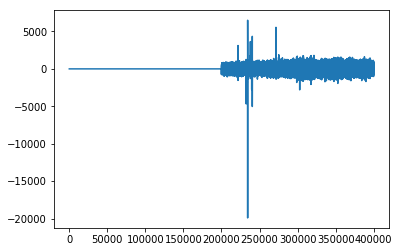

In [42]:
plt.plot(denoise_fft(subset_train.iloc[:, 230]))

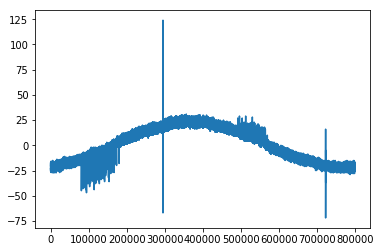

In [54]:
plt.plot(irfft(rfft(subset_train.iloc[:, 230])))

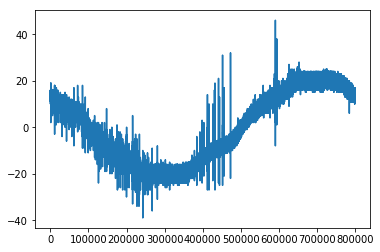

In [58]:
plt.plot(subset_train.iloc[:, 202])

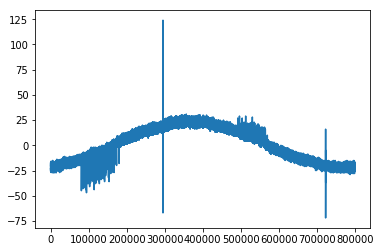

In [55]:
plt.plot(subset_train.iloc[:, 230])

In [106]:
x_hp = high_pass_filter(subset_train.iloc[:, 230], low_cutoff=10000, sample_rate=sample_rate)

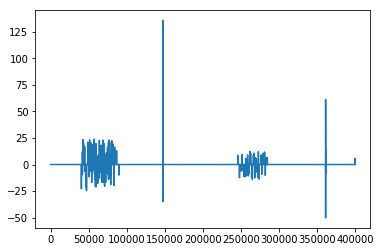

In [107]:
coeff = pywt.wavedec( x_hp, 'db4', mode="per", level=1)

sigma = (1/0.6745) * maddest( coeff[-1] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( x_hp ) ) )
coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

x_dn = pywt.waverec( coeff[1:], 'db4', mode='per' )
plt.plot(x_dn)

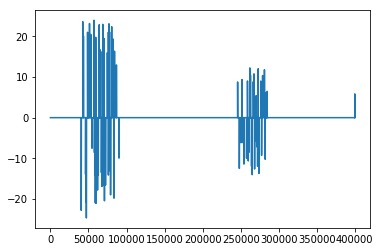

In [108]:
plt.plot(remove_colona(x_dn))

In [99]:
x_dn = pd.Series(x_dn)
x_dn.loc[x_dn!=0]

35740    -12.824940
63156    -13.137186
73791    -15.496076
88077    -12.002238
94932    -11.583381
97861    -11.748722
108013   -16.131616
108435    11.863494
111954   -13.001263
116949   -14.523284
121390    13.694188
206363   -12.090636
206368   -12.542179
208442   -11.808022
213397   -11.766574
215578    17.887237
216270    19.640511
216272    15.599131
220921    20.890039
220923    12.384587
226225    24.869197
226226   -14.178921
226227    13.390295
226229    14.311075
228310    16.584340
236676    27.925078
236680    16.414967
295652    19.044364
297445    13.790664
dtype: float64

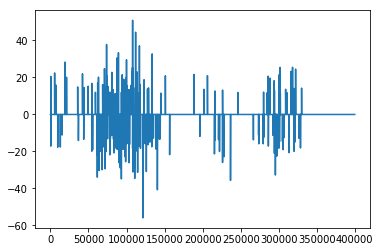

In [64]:
coeff = pywt.wavedec( subset_train.iloc[:, 201], 'db4', mode="per", level=1)

sigma = (1/0.6745) * maddest( coeff[-1] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( subset_train.iloc[:, 201] ) ) )
coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

plt.plot(pywt.waverec( coeff[1:], 'db4', mode='per' ))

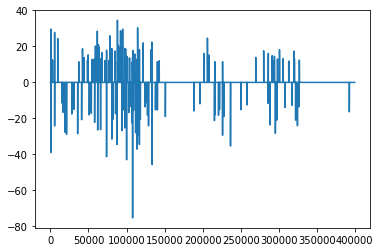

In [65]:
coeff = pywt.wavedec( subset_train.iloc[:, 203], 'db4', mode="per", level=1)

sigma = (1/0.6745) * maddest( coeff[-1] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( subset_train.iloc[:, 203] ) ) )
coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

plt.plot(pywt.waverec( coeff[1:], 'db4', mode='per' ))

In [66]:
def remove_colona(x_dn, maxDistance=10, maxHeightRatio=0.25, maxTicksRemoval=500):    
    index = pd.Series(x_dn).loc[np.abs(x_dn)>0].index
    for idx in index:
        for i in range(1,maxDistance+1):
            if idx+i < pd.Series(x_dn).shape[0]:
                if x_dn[idx+i]/(x_dn[idx]+1e-04)<-maxHeightRatio:
                    x_dn[idx:idx+maxTicksRemoval] = 0
    return x_dn

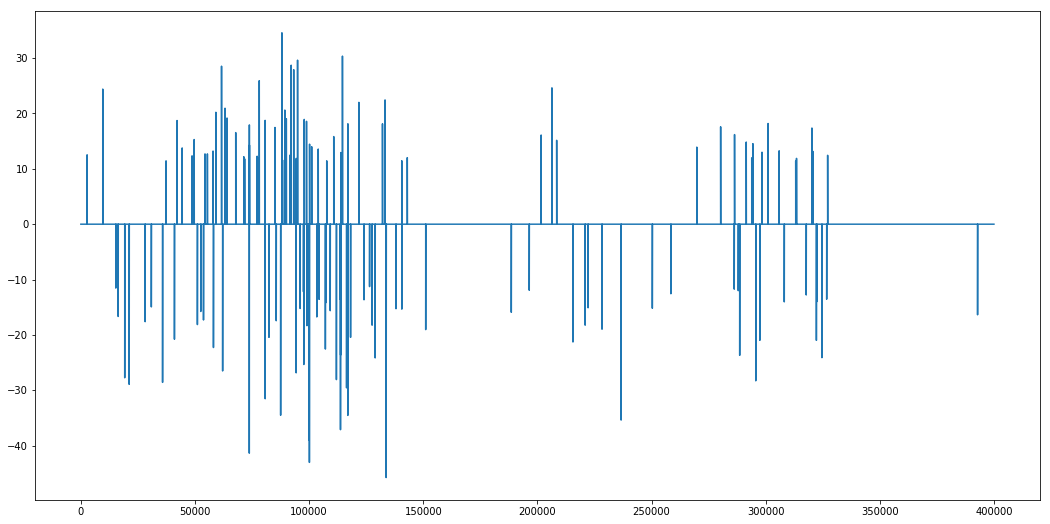

In [84]:
x_dn = pywt.waverec( coeff[1:], 'db4', mode='per' )
plt.figure(figsize=(18,9))
plt.plot(remove_colona(x_dn)[:400000])

In [78]:
list(pd.Series(remove_colona(x_dn)).loc[np.abs(remove_colona(x_dn))>0].index)

[2742,
 9588,
 9590,
 9591,
 15303,
 16354,
 16357,
 19214,
 19218,
 21185,
 21186,
 28172,
 30876,
 35797,
 37324,
 41000,
 41001,
 42151,
 44383,
 48710,
 49648,
 51056,
 52534,
 53728,
 54385,
 55434,
 57912,
 58088,
 58089,
 59146,
 61628,
 61629,
 61656,
 62106,
 62107,
 63156,
 63157,
 63343,
 64035,
 67841,
 67842,
 71376,
 71758,
 73789,
 73790,
 73818,
 73850,
 77226,
 77707,
 78158,
 78159,
 80734,
 80758,
 80759,
 82410,
 85042,
 85598,
 87518,
 87519,
 88077,
 88078,
 88349,
 89360,
 89386,
 89423,
 90011,
 91532,
 91984,
 92147,
 92148,
 93237,
 93238,
 94329,
 94330,
 94358,
 94932,
 94933,
 96072,
 97517,
 97679,
 97680,
 97861,
 97862,
 98852,
 99048,
 99991,
 99992,
 100122,
 100123,
 100197,
 101122,
 103361,
 103997,
 104369,
 107114,
 107115,
 107297,
 107713,
 109247,
 109248,
 110778,
 111952,
 111953,
 111980,
 111981,
 113541,
 113737,
 113738,
 113796,
 113797,
 113871,
 114599,
 114600,
 116398,
 116947,
 116948,
 116976,
 118153,
 121787,
 124049,
 124050,
 1

In [81]:
pd.set_option('display.max_rows', 600)
pd.set_option('display.max_columns', 200)

pd.Series(remove_colona(x_dn))[np.abs(remove_colona(x_dn))>0]

2742      12.525059
9588      14.265858
9590      13.439570
9591      24.395848
15303    -11.535259
16354    -11.617115
16357    -16.662148
19214    -27.735341
19218    -14.403521
21185    -28.923483
21186    -15.187601
28172    -17.606628
30876    -14.937556
35797    -28.565957
37324     11.434617
41000    -20.772238
41001    -13.226140
42151     18.716256
44383     13.767513
48710     12.339388
49648     15.286870
51056    -18.128997
52534    -15.761062
53728    -17.300473
54385     12.690768
55434     12.690765
57912     13.210975
58088    -12.448381
58089    -22.270881
59146     20.206529
61628     28.530087
61629     16.475869
61656     11.415815
62106    -16.243208
62107    -26.502255
63156     13.269019
63157     20.942081
63343     12.647586
64035     19.174958
67841     16.540968
67842     12.241861
71376     12.184423
71758     11.791496
73789    -21.269794
73790    -41.345568
73818     17.924890
73850     14.269960
77226     12.268062
77707     11.865031
78158     25.914841


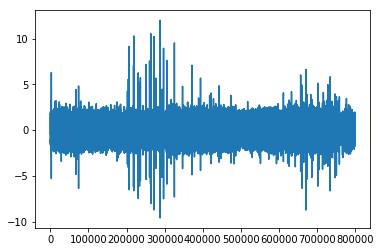

In [53]:
plt.plot(irfft(denoise_fft(subset_train.iloc[:, 271])))

In [ ]:
plt.figure(figsize=(18,9))
plt.plot(x_dn)

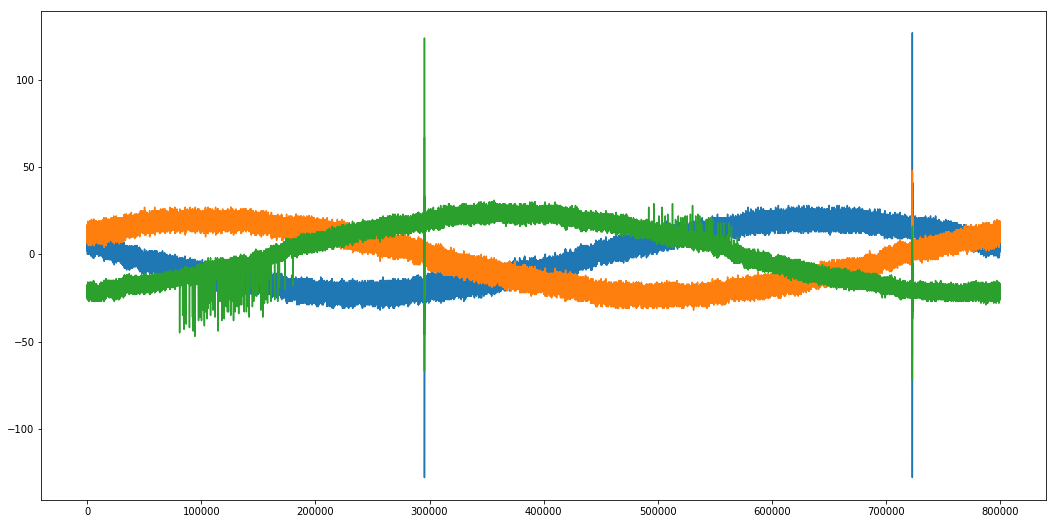

In [86]:
plt.figure(figsize=(18,9))
plt.plot(subset_train.iloc[:, 228])
plt.plot(subset_train.iloc[:, 229])
plt.plot(subset_train.iloc[:, 230])

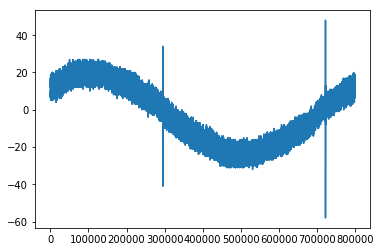

In [87]:
plt.plot(subset_train.iloc[:, 229])

In [26]:
pd.Series(x_dn).loc[np.abs(x_dn)>3]

265722     5.977270
265723    -5.977305
265724   -11.991778
265726     4.969417
265727     4.969417
275735   -10.999176
275736    -7.700714
275738    11.290901
286674    -7.369527
286675    -7.369527
286676     3.161783
286677     3.161783
286678     3.161783
286679     3.161783
307756    -4.495150
307757    -4.495150
307758   -12.030196
307759     3.039895
307766    -6.275318
307767    -6.275318
342188     3.732243
342189     3.732243
342191    -9.696490
370524    -3.494398
370525    -3.494398
370526     3.494363
370527     3.494363
413410     5.483891
413411    -5.483926
425202    -6.100168
            ...    
704495    -3.487703
714064     9.610381
714065     9.610381
714066    -4.926367
714067    -4.926367
750328    13.367192
754013    15.254319
754015    -7.854310
754016    -7.380461
754022     6.707342
754023     6.707342
754068    -3.210853
754069    -3.210853
769188     4.534387
769189     4.534387
769191    -9.024334
783658    25.664089
783659     8.466114
783660    -6.570612


In [62]:
x_hp = high_pass_filter(subset_train.iloc[:,5], low_cutoff=10000, sample_rate=sample_rate)

x_dn = denoise_signal(x_hp, wavelet='haar', level=1)

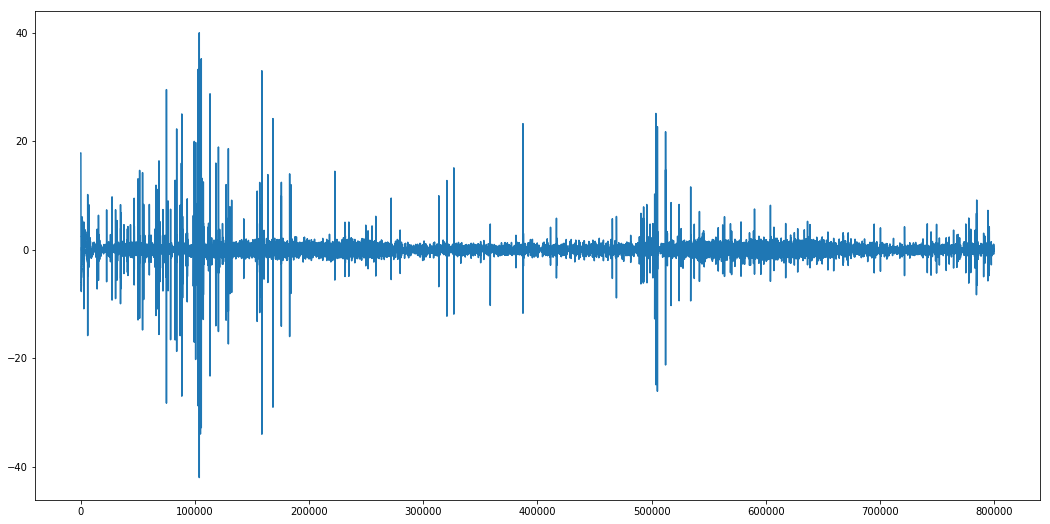

In [63]:
plt.figure(figsize=(18,9))
plt.plot(x_dn)

In [193]:
x_hp = high_pass_filter(subset_train.iloc[:,2], low_cutoff=10000, sample_rate=sample_rate)

x_dn = denoise_signal(x_hp, wavelet='haar', level=1)

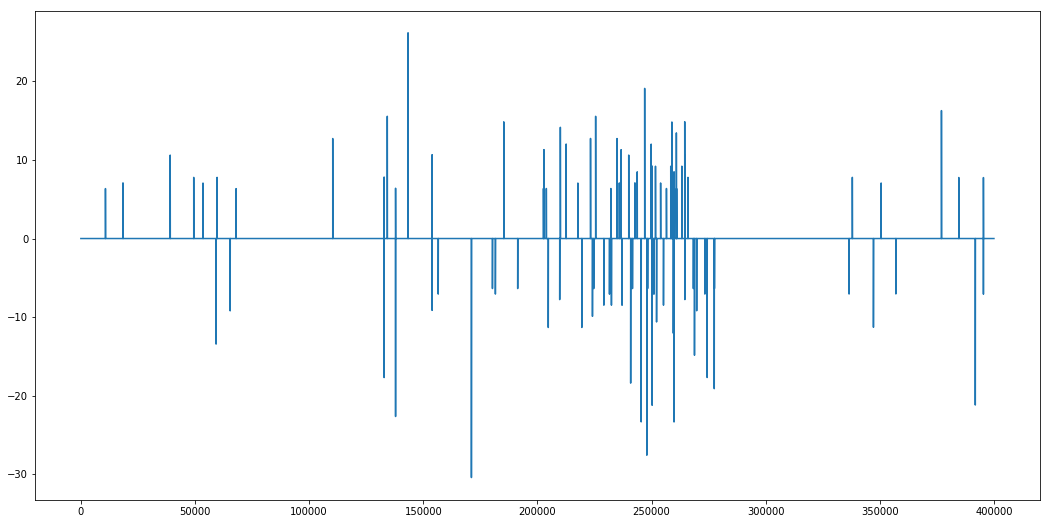

In [194]:
plt.figure(figsize=(18,9))
plt.plot(x_dn)

In [161]:
level = 1

In [195]:
coeff = pywt.wavedec( x_hp, 'db4', mode="per", level=1 )

In [196]:
sigma = (1/0.6745) * maddest( coeff[-level] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( x_hp ) ) )

In [197]:
uthresh

6.389936276474933

In [199]:
coeff = pywt.threshold( coeff, value=uthresh, mode='hard' )

In [167]:
coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

In [201]:
plt.figure(figsize=(18,9))
plt.plot(pywt.waverec( coeff, 'db4', mode='per' ))

ValueError: Expected sequence of coefficient arrays.

<Figure size 1296x648 with 0 Axes>

In [170]:
level = 1

In [171]:
coeff = pywt.wavedec( x_hp, 'haar', mode="per", level=1 )

In [172]:
sigma = (1/0.6745) * maddest( coeff[-level] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( x_hp ) ) )

In [173]:
uthresh

5.98054828691554

In [174]:
coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

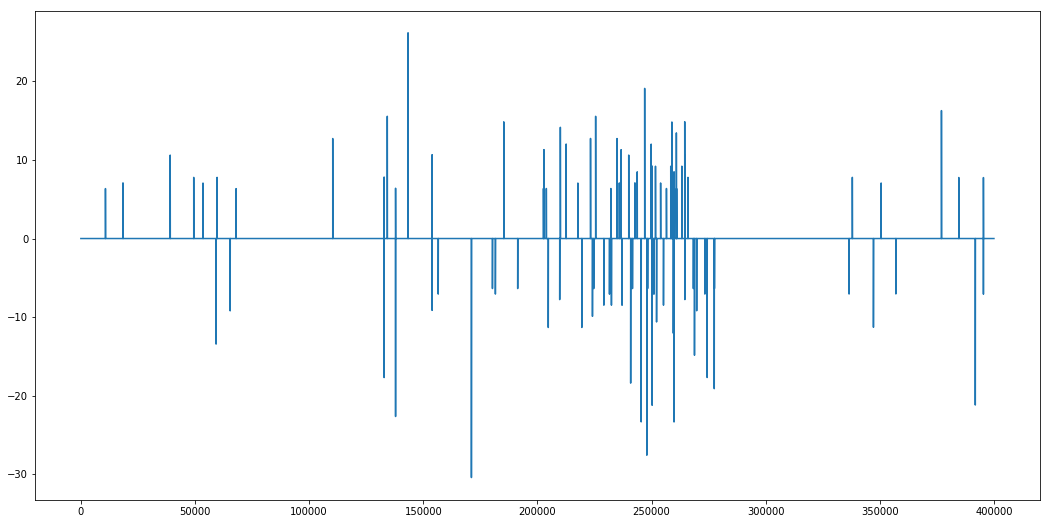

In [182]:
plt.figure(figsize=(18,9))
plt.plot(pywt.waverec( coeff[1:], 'haar', mode='per' ))

In [177]:
coeff[0]

array([-26.60126261, -26.76354208, -26.22772745, ...,   0.67893442,
        -0.03840959,   0.65855332])

In [180]:
coeff[1]

array([0., 0., 0., ..., 0., 0., 0.])

In [ ]:
# Decompose to get the wavelet coefficients
coeff = pywt.wavedec( x, wavelet, mode="per" )

# Calculate sigma for threshold as defined in http://dspace.vsb.cz/bitstream/handle/10084/133114/VAN431_FEI_P1807_1801V001_2018.pdf
# As noted by @harshit92 MAD referred to in the paper is Mean Absolute Deviation not Median Absolute Deviation
sigma = (1/0.6745) * maddest( coeff[-level] )

# Calculte the univeral threshold
uthresh = sigma * np.sqrt( 2*np.log( len( x ) ) )
coeff[1:] = ( pywt.threshold( i, value=uthresh, mode='hard' ) for i in coeff[1:] )

# Reconstruct the signal using the thresholded coefficients
return pywt.waverec( coeff, wavelet, mode='per' )